<h1><center>Feature Engineering Notebook: Prices + News </h1> <center>
This notebook builds modeling features from historical prices and news.
It creates price/volume technicals, momentum/volatility, and text-based signals (news counts and sentiment) with proper lags to avoid leakage.

**Outputs**: a clean features table saved to `data/features.parquet` and `data/features.csv`.

In [3]:
# %%
# Imports
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path

# Optional: sentiment (VADER)
try:
    from nltk.sentiment import SentimentIntensityAnalyzer
    import nltk
    _HAVE_VADER = True
except Exception:
    _HAVE_VADER = False

# %% [markdown]
# ## 1) Load data
# Assumes local files in `data/price.csv` and `data/news.csv` created earlier.

# %%


PRICES_PATH = "../data/price.csv"
NEWS_PATH   = "../data/news.csv"

price_df = pd.read_csv(PRICES_PATH)
news_df  = pd.read_csv(NEWS_PATH)

# Basic typing/cleaning
price_df['date'] = pd.to_datetime(price_df['date'])
price_df['ticker'] = price_df['ticker'].str.upper()

news_df['datetime'] = pd.to_datetime(news_df['datetime'], errors='coerce')
news_df = news_df.dropna(subset=['datetime']).copy()
news_df['ticker'] = news_df['ticker'].str.upper()
news_df['date'] = pd.to_datetime(news_df['datetime'].dt.date)

# Drop exact dups
news_df = news_df.drop_duplicates(subset=['ticker','datetime','headline','summary'])

 ## 2) Aggregate news by (ticker, date)
 We build daily text and counts. If you later compute per-article sentiment,
 aggregate here similarly (mean/max/etc.).


In [4]:

# Combine headline + summary per row (fallback-safe)
text_cols = news_df[['headline','summary']].fillna('')
news_df['text'] = (text_cols['headline'].str.strip() + '. ' + text_cols['summary'].str.strip()).str.strip('. ')

# Aggregate per day
news_agg = (
    news_df.groupby(['ticker','date'], as_index=False)
           .agg(
               aggregated_text=('text', lambda s: ' '.join(map(str, s))),
               headline=('headline', lambda s: ' '.join(map(str, s))),
               summary=('summary', lambda s: ' '.join(map(str, s))),
               news_count=('datetime','count')
           )
)

## 3) Merge prices + news

In [7]:
price_df = price_df.sort_values(['ticker','date']).reset_index(drop=True)
news_agg = news_agg.sort_values(['ticker','date']).reset_index(drop=True)

merged = price_df.merge(news_agg, on=['ticker','date'], how='left')

for col in ['aggregated_text','headline','summary']:
    if col in merged:
        merged[col] = merged[col].fillna('')
merged['news_count'] = merged['news_count'].fillna(0).astype(int)

## 4) Helper functions (rolling technicals, momentum, sentiment)

In [8]:

TRADING_DAYS = 252

def add_price_core(df: pd.DataFrame) -> pd.DataFrame:
    out = df.copy()
    out = out.sort_values(['ticker','date'])
    out['close'] = pd.to_numeric(out['close'], errors='coerce')
    out['volume'] = pd.to_numeric(out['volume'], errors='coerce')

    # Returns
    out['daily_return'] = out.groupby('ticker', sort=False)['close'].pct_change()
    out['log_return']   = np.log1p(out['daily_return'])

    # Volatility windows
    for w in (7, 21, 63):
        out[f'vol_{w}d'] = (
            out.groupby('ticker', sort=False)['daily_return']
               .transform(lambda s: s.rolling(w, min_periods=max(3,w//2)).std())
        )

    # Momentum (close_t / close_{t-w} - 1)
    for w in (5, 10, 20):
        out[f'mom_{w}d'] = out.groupby('ticker', sort=False)['close'].transform(lambda s: s / s.shift(w) - 1)

    # Moving averages
    out['sma_20'] = out.groupby('ticker', sort=False)['close'].transform(lambda s: s.rolling(20, min_periods=5).mean())
    out['ema_20'] = out.groupby('ticker', sort=False)['close'].transform(lambda s: s.ewm(span=20, adjust=False).mean())

    # RSI (Wilder)
    delta = out.groupby('ticker', sort=False)['close'].diff()
    gain = delta.clip(lower=0)
    loss = -delta.clip(upper=0)
    avg_gain = gain.groupby(out['ticker']).transform(lambda s: s.ewm(alpha=1/14, adjust=False, min_periods=14).mean())
    avg_loss = loss.groupby(out['ticker']).transform(lambda s: s.ewm(alpha=1/14, adjust=False, min_periods=14).mean())
    rs = avg_gain / avg_loss.replace(0, np.nan)
    rsi = 100 - (100 / (1 + rs))
    rsi = pd.Series(rsi).fillna(50)
    out['rsi'] = rsi.values

    # Bollinger bands (20)
    mid = out.groupby('ticker', sort=False)['close'].transform(lambda s: s.rolling(20, min_periods=20).mean())
    std = out.groupby('ticker', sort=False)['close'].transform(lambda s: s.rolling(20, min_periods=20).std())
    out['bb_mid'] = mid
    out['bb_high'] = mid + 2*std
    out['bb_low']  = mid - 2*std
    out['bb_percent_b'] = (out['close'] - out['bb_low']) / (out['bb_high'] - out['bb_low'])

    # Volume features
    out['volu_sma_20'] = out.groupby('ticker', sort=False)['volume'].transform(lambda s: s.rolling(20, min_periods=5).mean())
    out['volu_ratio']  = out['volume'] / out['volu_sma_20']

    return out


def add_news_features(df: pd.DataFrame, use_vader=True) -> pd.DataFrame:
    out = df.copy()
    # Headline length as proxy of info load
    out['headline_len'] = out['headline'].fillna('').astype(str).str.split().str.len()

    # Sentiment with VADER (if available) on aggregated_text; shift by 1 day to avoid leakage
    if use_vader and _HAVE_VADER:
        try:
            nltk.download('vader_lexicon', quiet=True)
            sia = SentimentIntensityAnalyzer()
            out['sentiment_raw'] = out['aggregated_text'].fillna('').astype(str).map(lambda t: sia.polarity_scores(t)['compound'])
        except Exception:
            out['sentiment_raw'] = 0.0
    else:
        out['sentiment_raw'] = 0.0  # safe default

    out['sentiment_lag1'] = out.groupby('ticker', sort=False)['sentiment_raw'].shift(1)

    # News count rolling stats
    for w in (1, 3, 7):
        out[f'news_count_sum_{w}d'] = out.groupby('ticker', sort=False)['news_count'].transform(lambda s: s.rolling(w, min_periods=1).sum())
        out[f'news_count_avg_{w}d'] = out.groupby('ticker', sort=False)['news_count'].transform(lambda s: s.rolling(w, min_periods=1).mean())

    return out


def add_lags(df: pd.DataFrame, cols, lags=(1,2)) -> pd.DataFrame:
    out = df.copy()
    for c in cols:
        for L in lags:
            out[f'{c}_lag{L}'] = out.groupby('ticker', sort=False)[c].shift(L)
    return out


## 5) Build features

In [9]:

features = add_price_core(merged)
features = add_news_features(features, use_vader=True)

# Add lags for a focused set of predictors
lag_cols = ['daily_return','vol_21d','mom_10d','rsi','sentiment_lag1','news_count']
features = add_lags(features, lag_cols, lags=(1,2,3))

# Target: next-day return and direction
features['target_return'] = features.groupby('ticker', sort=False)['daily_return'].shift(-1)
features['target_up'] = (features['target_return'] > 0).astype(int)

# Drop rows that would leak or are incomplete
drop_cols_for_na = ['daily_return','target_return']
features_clean = features.dropna(subset=drop_cols_for_na).reset_index(drop=True)

print("Features shape:", features_clean.shape)
features_clean.head()

Features shape: (1673, 57)


[nltk_data] Error loading vader_lexicon: <urlopen error [SSL:
[nltk_data]     CERTIFICATE_VERIFY_FAILED] certificate verify failed:
[nltk_data]     unable to get local issuer certificate (_ssl.c:1000)>


,date,ticker,open,high,low,close,volume,aggregated_text,headline,summary,...,rsi_lag2,rsi_lag3,sentiment_lag1_lag1,sentiment_lag1_lag2,sentiment_lag1_lag3,news_count_lag1,news_count_lag2,news_count_lag3,target_return,target_up
0,2023-11-14,AAPL,187.699997,188.110001,186.300003,187.440002,60108400,"Apple supplier Foxconn's Q3 profit rises 11%, ...","Apple supplier Foxconn's Q3 profit rises 11%, ...",Apple Inc supplierFoxconn reported on Tuesday ...,...,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,0.003041,1
1,2023-11-15,AAPL,187.850006,189.500000,187.779999,188.009995,53790500,,,,...,50.0,NaN,0.0,NaN,NaN,1.0,1.0,NaN,0.009042,1
2,2023-11-16,AAPL,189.570007,190.960007,188.649994,189.710007,54412900,Apple's Effort To Replace Qualcomm Chip In iPh...,Apple's Effort To Replace Qualcomm Chip In iPh...,Nov 16 - * APPLE’S EFFORT TO REPLACE QUALCOMM ...,...,50.0,50.0,0.0,0.0,NaN,0.0,1.0,1.0,-0.000105,0
3,2023-11-17,AAPL,190.250000,190.380005,188.570007,189.690002,50922700,K-pop star Rosé joins first lady Jill Biden to...,K-pop star Rosé joins first lady Jill Biden to...,SAN FRANCISCO — K-pop superstar Rosé said Frid...,...,50.0,50.0,0.0,0.0,0.0,6.0,0.0,1.0,0.009278,1
4,2023-11-20,AAPL,189.889999,191.910004,189.880005,191.449997,46505100,,,,...,50.0,50.0,0.0,0.0,0.0,3.0,6.0,0.0,-0.004231,0


 ## 6) (Optional) Train/validation split by time
 Create a reproducible temporal split per ticker for later modeling.

In [10]:
# %%
# Choose a split date (e.g., last 20% of each ticker as validation)
features_clean = features_clean.sort_values(['ticker','date']).reset_index(drop=True)

# Simple time-based split index per ticker
split_idx = (
    features_clean.groupby('ticker')['date']
    .transform(lambda s: s.rank(method='first') / len(s))
)

features_clean['split'] = np.where(split_idx >= 0.8, 'valid', 'train')
features_clean['split'].value_counts()

split
train    1337
valid     336
Name: count, dtype: int64

## 7) Save artifacts

In [12]:

# %%
OUT_PARQUET = '../data/features.parquet'
OUT_CSV     = '../data/features.csv'


features_clean.to_csv(OUT_CSV, index=False)


print(f"Saved: {OUT_CSV}")

Saved: ../data/features.csv


  ticker       date  daily_return  vol_21d  mom_10d   rsi  sentiment_lag1  \
0   AAPL 2023-11-14      0.014286      NaN      NaN  50.0             0.0   
1   AAPL 2023-11-15      0.003041      NaN      NaN  50.0             0.0   
2   AAPL 2023-11-16      0.009042      NaN      NaN  50.0             0.0   
3   AAPL 2023-11-17     -0.000105      NaN      NaN  50.0             0.0   
4   AAPL 2023-11-20      0.009278      NaN      NaN  50.0             0.0   

   news_count_sum_7d  
0                2.0  
1                2.0  
2                8.0  
3               11.0  
4               11.0  


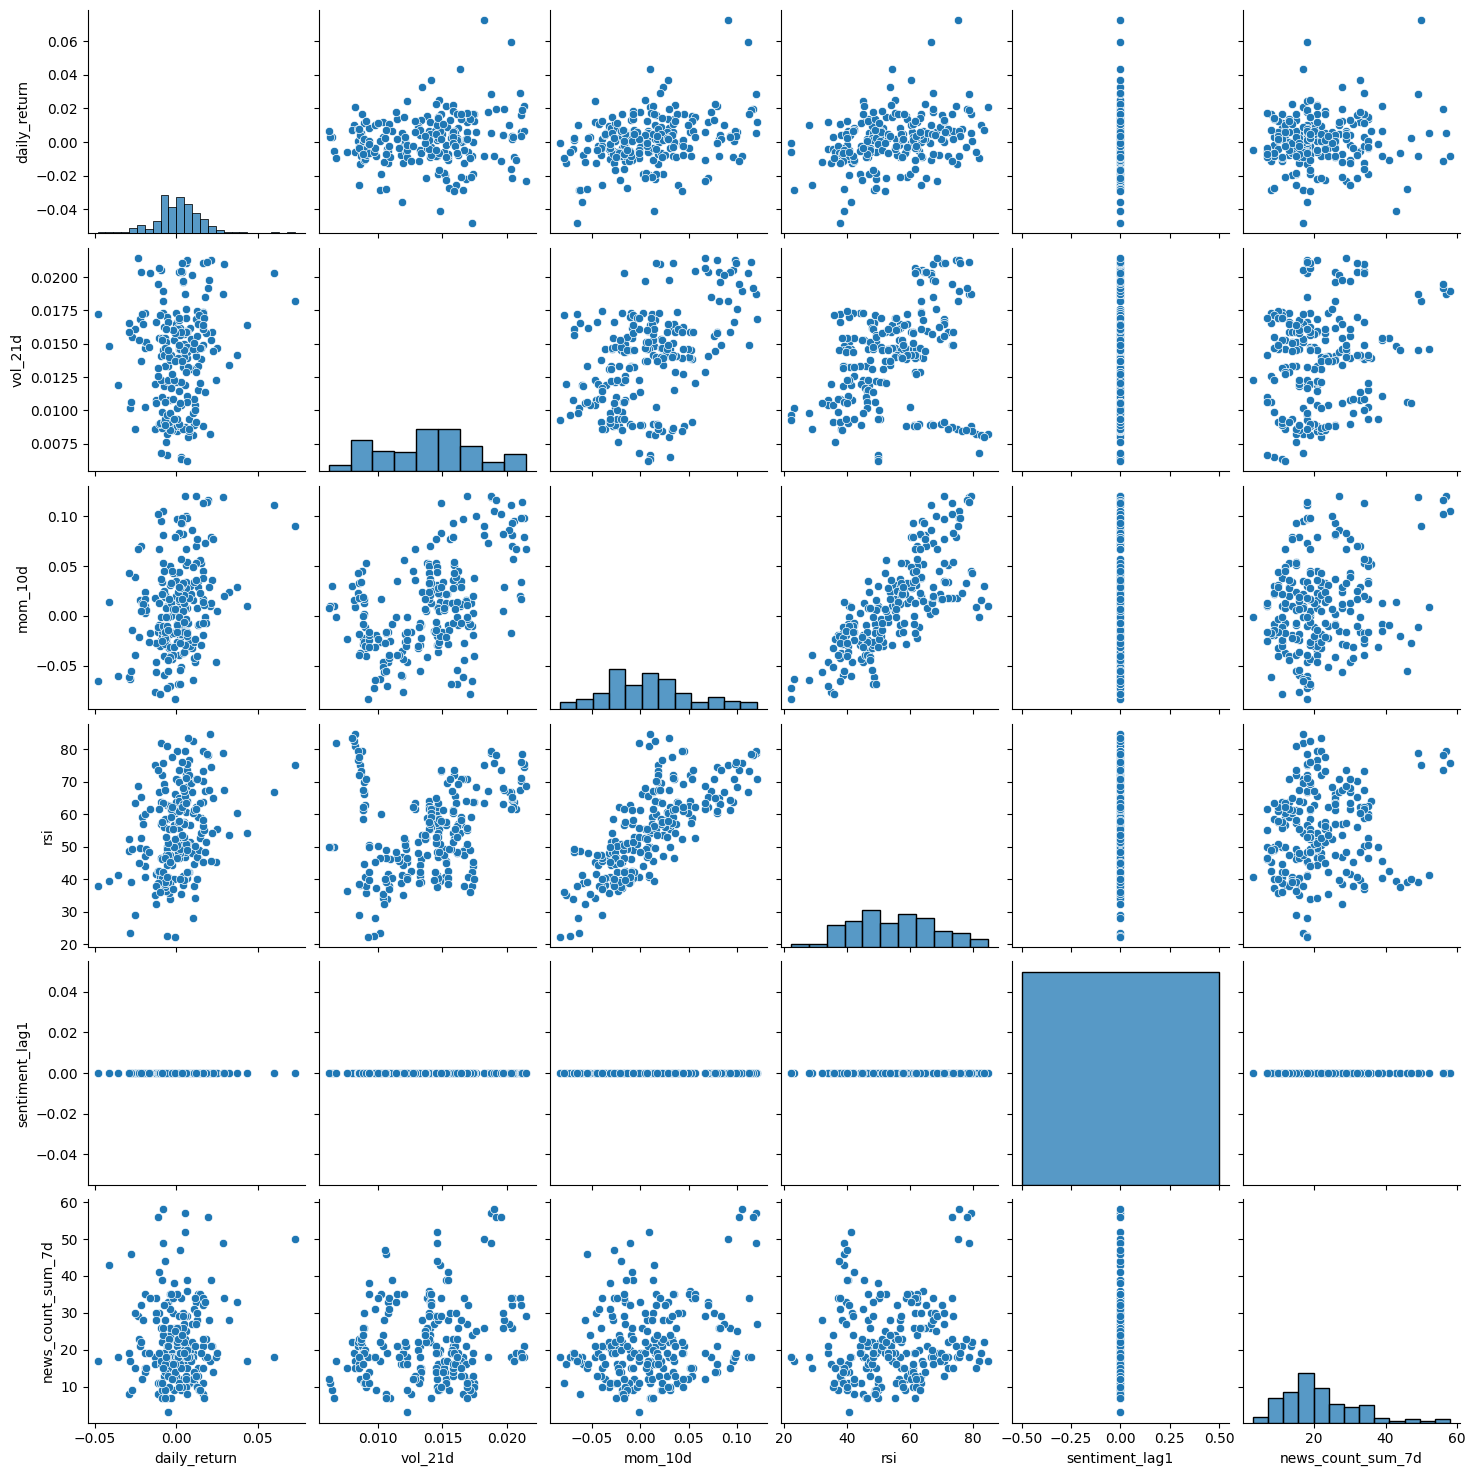

In [15]:


# %% [markdown]
# ## 8) Quick sanity checks (optional plotting)

# %%
# Quick check of a couple of columns
check_cols = ['daily_return','vol_21d','mom_10d','rsi','sentiment_lag1','news_count_sum_7d']
print(features_clean[['ticker','date'] + check_cols].head())

# Example distribution plot
import seaborn as sns
sns.pairplot(features_clean[features_clean['ticker']==features_clean['ticker'].unique()[0]][check_cols].dropna())
plt.show()
